In [1]:
# Imports 
import os
import sys
from io import StringIO
sys.path.append("..")
os.environ["pyna_language"] = 'julia'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Inputs 
lateral_attenuation = True

z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444

ipnlt_constraint = dict()
if lateral_attenuation:
    ipnlt_constraint['stca'] = dict() 
    ipnlt_constraint['stca']['V2']   = 93.55447605691045 + 0.25
    ipnlt_constraint['stca']['Vmax'] = 89.0961292464429 + 0.25
    ipnlt_constraint['a10'] = dict()
    ipnlt_constraint['a10']['V2']   = 95.56624688263544 + 0.25
    ipnlt_constraint['a10']['Vmax'] = 93.54779306897042 + 0.25
else:
    ipnlt_constraint['stca'] = dict() 
    ipnlt_constraint['stca']['V2']   = 96.02493283 + 0.25
    ipnlt_constraint['stca']['Vmax'] = 94.18717742 + 0.25
    ipnlt_constraint['a10'] = dict()
    ipnlt_constraint['a10']['V2']   = 101.40068049 + 0.25
    ipnlt_constraint['a10']['Vmax'] = 101.08742362 + 0.25
    
k_lst = dict()
k_lst['stca'] = dict()
k_lst['stca']['V2'] = 1.24204863
k_lst['stca']['Vmax'] = 1.59999739
k_lst['a10'] = dict()
k_lst['a10']['V2'] = 1.41274722
k_lst['a10']['Vmax'] = 1.52464716

# PTCB trajectories

In [ ]:
# PTCB
if True:
    
    for ac_name in ['stca', 'a10']:
    
        for ii, case in enumerate(['V2', 'Vmax']):

            if True:
                # Load verification trajectory 
                nasa_std = pd.read_csv('../cases/nasa_stca_standard/trajectory/Trajectory_to.csv')

                pyna_settings = pyna.load_settings(case_name=ac_name)
                pyna_settings.ac_name = ac_name
                pyna_settings.engine_file_name = 'engine_deck_'+ac_name+'.csv'
                pyna_settings.TS_to = 1.
                pyna_settings.TS_vnrs = TS_cb_lst[ac_name][case][0]
                pyna_settings.TS_cutback = TS_cb_lst[ac_name][case][0]
                pyna_settings.save_results = True
                pyna_settings.levels_int_metric = 'ipnlt'
                pyna_settings.output_directory_name = 'PTCB/'+case
                pyna_settings.output_file_name = ac_name+'_ptcb_'+case+'.sql'

                pyna_settings.noise_constraint_lateral = ipnlt_constraint[ac_name][case]
                pyna_settings.PTCB = True
                pyna_settings.PKROT = False
                pyna_settings.PHLD = False
                pyna_settings.shielding = False
                pyna_settings.lateral_attenuation = True

                pyna_settings.fan_inlet = True
                pyna_settings.fan_discharge = True
                pyna_settings.core = True
                pyna_settings.airframe = False
                pyna_settings.jet_shock = False
                pyna_settings.jet_mixing = True
                pyna_settings.all_sources = False

                # Simplifications
                pyna_settings.N_b = 1
                pyna_settings.max_iter = 200
                pyna_settings.n_order = 3

                py = pyna(pyna_settings)
                py.ac.k_rot = k_lst[ac_name][case]
                py.ac.v_max = Vmax_lst[ac_name][case]

            if True:
                if ac_name == 'stca' and case == 'V2':
                    x_observer_array = np.linspace(1000, 6200, 14)
                elif ac_name == 'stca' and case == 'Vmax':
                    x_observer_array = np.linspace(1000, 6200, 14)
                elif ac_name == 'a10' and case == 'V2':
                    x_observer_array = np.linspace(2000, 8000, 16)
                elif ac_name == 'a10' and case == 'Vmax':
                    x_observer_array = np.linspace(2000, 8000, 16)
                
                py.optimize_trajectory_noise(x_lateral_oberver=x_observer_array, init_traj_name=None)

            if True:
                results = py.load_results(file_name=ac_name+'_ptcb_'+case+'.sql')

                path_save_name = 'trajectory_' + ac_name + '_ptcb_' + case + '.csv'
                engine_save_name = 'engine_' + ac_name + '_ptcb_' + case + '.csv' 
                py.save_time_series(results, py.settings, py.ac, path_save_name, engine_save_name)

            if True:
                n_sl = 131  

                py.settings.engine_file_name = 'engine_'+ac_name+'_ptcb_'+case+'.csv'
                py.settings.trajectory_file_name = 'trajectory_'+ac_name+'_ptcb_'+case+'.csv'
                py.settings.output_file_name = ac_name+'_ptcb_'+case+'_noisetimeseries.sql'
                py.settings.observer_lst = ['contour',]
                py.settings.levels_int_metric = 'epnl'

                py.settings.fan_inlet = True
                py.settings.fan_discharge = True
                py.settings.core = True
                py.settings.airframe = True
                py.settings.jet_shock = False
                py.settings.jet_mixing = True
                py.settings.all_sources = False

                x_observer_lst = np.zeros((n_sl+1, 3))
                x_observer_lst[:-1, 0] = np.linspace(0, 6500, n_sl)
                x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
                x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
                x_observer_lst[-1,0] = 6500.

                py.settings.x_observer_array = x_observer_lst
                py.compute_noise_time_series()

                epnl_sideline = py.problem.get_val('noise.epnl')[:-1]
                epnl_lateral = np.max(py.problem.get_val('noise.epnl')[:-1])
                epnl_flyover = py.problem.get_val('noise.epnl')[-1]

            if True:
                np.save('../cases/'+ac_name+'/output/PTCB/'+case+'/epnl_lateral.npy', epnl_lateral)
                np.save('../cases/'+ac_name+'/output/PTCB/'+case+'/epnl_flyover.npy', epnl_flyover)
                np.save('../cases/'+ac_name+'/output/PTCB/'+case+'/epnl_sideline.npy', epnl_sideline)

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/utils/options_dictionary.py:332: OMDeprecationWarning:'gradient method' is not a valid python name and will become an invalid option name in a future release. You can prevent this warning (and future exceptions) by declaring this option using a valid python name.


--- Linkage Report [phases] ---
    --- groundroll - rotation ---
        time           [final] ==  time           [initial]
        states:x       [final] ==  states:x       [initial]
        states:v       [final] ==  states:v       [initial]
        states:alpha   [final] ==  states:alpha   [initial]
    --- rotation - liftoff ---
        time               [final] ==  time             [initial]
        states:x           [final] ==  states:x         [initial]
        parameters:z       [final*] ==  states:z         [initial]
        states:v           [final] ==  states:v         [initial]
        states:alpha       [final] ==  controls:alpha   [initial]
        parameters:gamma   [final*] ==  states:gamma     [initial]
    --- liftoff - vnrs ---
        time             [final] ==  time             [initial]
        states:x         [final] ==  states:x         [initial]
        states:v         [final] ==  states:v         [initial]
        controls:alpha   [final] ==  controls:

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 4.547203 seconds.
Total jacobian shape: (255, 178) 


Jacobian shape: (255, 178)  ( 3.78% nonzero)
FWD solves: 11   REV solves: 0
Total colors vs. total size: 11 vs 178  (93.8% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 4.547203 sec.
Time to compute coloring: 0.143318 sec.


Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    5.5143
       User Objective Time :       0.7022
       User Sensitivity Time :     4.3565
       Interface Time :            0.4173
       Opt Solver Time:            0.0383
    Calls to Objective Function :      14
    Calls to Sens Function :           14


   Objectives
     

--- Linkage Report [phases] ---
    --- groundroll - rotation ---
        time           [final] ==  time           [initial]
        states:x       [final] ==  states:x       [initial]
        states:v       [final] ==  states:v       [initial]
        states:alpha   [final] ==  states:alpha   [initial]
    --- rotation - liftoff ---
        time               [final] ==  time             [initial]
        states:x           [final] ==  states:x         [initial]
        parameters:z       [final*] ==  states:z         [initial]
        states:v           [final] ==  states:v         [initial]
        states:alpha       [final] ==  controls:alpha   [initial]
        parameters:gamma   [final*] ==  states:gamma     [initial]
    --- liftoff - vnrs ---
        time             [final] ==  time             [initial]
        states:x         [final] ==  states:x         [initial]
        states:v         [final] ==  states:v         [initial]
        controls:alpha   [final] ==  controls:

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/output/PTCB/V2/stca_ptcb_V2.sql, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 595.140953 seconds.
Total jacobian shape: (263, 193) 


Jacobian shape: (263, 193)  ( 4.44% nonzero)
FWD solves: 14   REV solves: 2
Total colors vs. total size: 16 vs 193  (91.7% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 595.140953 sec.
Time to compute coloring: 0.525938 sec.

+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 


+------------------------------------------------------------------------------+
| pyOptSparse Error: No constraint values were found for the constraint        |
| 'phases.phases.groundroll.final_boundary_constraints.final_value:v_rot_residual'. |
+------------------------------------------------------------------------------+



Error: 

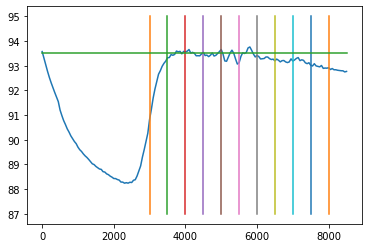

In [17]:
plt.plot(np.linspace(0, 8500, 171), epnl_sideline)
for i in np.linspace(3000, 8000, 11):
    plt.plot([i, i], [87, 95])
plt.plot([0, 8500], [93.5, 93.5])

In [11]:
if True:
    n_sl = 171  

    py.settings.engine_file_name = 'engine_'+ac_name+'_ptcb_'+case+'.csv'
    py.settings.trajectory_file_name = 'trajectory_'+ac_name+'_ptcb_'+case+'.csv'
    py.settings.output_file_name = ac_name+'_ptcb_'+case+'_noisetimeseries.sql'
    py.settings.observer_lst = ['contour',]
    py.settings.levels_int_metric = 'epnl'

    py.settings.fan_inlet = True
    py.settings.fan_discharge = True
    py.settings.core = True
    py.settings.airframe = True
    py.settings.jet_shock = False
    py.settings.jet_mixing = True
    py.settings.all_sources = False

    x_observer_lst = np.zeros((n_sl+1, 3))
    x_observer_lst[:-1, 0] = np.linspace(0, 8500, n_sl)
    x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
    x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
    x_observer_lst[-1,0] = 6500.

    py.settings.x_observer_array = x_observer_lst
    py.compute_noise_time_series()

    epnl_sideline = py.problem.get_val('noise.epnl')[:-1]
    epnl_lateral = np.max(py.problem.get_val('noise.epnl')[:-1])
    epnl_flyover = py.problem.get_val('noise.epnl')[-1]


/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/a10/output/a10_ptcb_Vmax_noisetimeseries.sql, is being overwritten.
/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/a10/dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
